# 1. 문제 정의

* **데이터셋 출처**
  https://www.kaggle.com/c/word2vec-nlp-tutorial

  

* **문제 정의**<br>
  영화평 감정분석을 하는 모델을 만들어 봅니다. 감정은 긍정/부정으로 나뉘어져있으므로 '이진분류'문제입니다.
'분류'문제를 해결하기 위한 Classifier를 모델로 설정하고, 모델 평가는 Accuracy를 사용할 수 있습니다.

* **데이터 필드**<br>
 - id: Unique ID of each review
 - sentiment: Sentiment of the review; 1 for positive reviews and 0 for negative reviews
 - review: Text of the review

라이브러리 임포트

In [1]:
import os
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import re
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords

seed = 0
np.random.seed(seed)

# 2. 데이터 전처리

데이터 로딩

In [2]:
df = pd.read_csv('./dataset/popcorn.tsv', header=0, delimiter="\t", quoting=3)
df.head()

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."


In [3]:
print('The first review is:')
print(df["review"][0])

The first review is:
"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ's feeling towards the press and also the obvious message of drugs are bad m'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bi

###  X, Y 데이터 분할

In [4]:
X = df["review"]
Y = df["sentiment"]

### Train-Test 분할

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=seed)

### 불용어 제거를 위한 corpora 다운로드

In [6]:
print('NLTK 데이터 셋을 다운로드 받습니다. Corpora 탭의 stopwords를 선택해주세요.\
      이미 다운로드 받았다면 생성된 창을 닫아주세요.')

nltk.download()

NLTK 데이터 셋을 다운로드 받습니다. Corpora 탭의 stopwords를 선택해주세요.      이미 다운로드 받았다면 생성된 창을 닫아주세요.
showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

### 불용어, 특수문자, 숫자 제거

In [7]:
 def review_to_wordlist(review, remove_stopwords=False ):
    # 1. HTML 파싱
    review_text = BeautifulSoup(review, "lxml").get_text()
   
    # 2. 문자, 공백을 제외한 특수문자와 숫자 제거
    review_text = re.sub("[^a-zA-Z]"," ", review_text)
   
    # 3. 소문자 변환 후 띄어쓰기 기준으로 분할
    words = review_text.lower().split()
   
    # 4. 불용어 제거
    if remove_stopwords:
        stops = set(stopwords.words("english"))
        words = [w for w in words if not w in stops]
  
    # 5. 전처리 완료 단어 리스트 반환
    return words

#### [TrainingSet]

In [8]:
clean_train_reviews = []

print("리뷰 데이터 전처리 진행 중... \n")
for i in range(0, len(X_train)):
    index = X_train.index[i]
    clean_train_reviews.append(" ".join(review_to_wordlist(X_train[index], True)))
print("리뷰 데이터 전처리 완료! \n")

리뷰 데이터 전처리 진행 중... 

리뷰 데이터 전처리 완료! 



In [9]:
# 원본 데이터
print(X_train[X_train.index[0]])

"Horrible acting, Bad story line, cheesy makeup, and this is just the tip of the iceberg. I have never seen a worse movie in my life, 5 minutes in I decided to fast forward to see if anything redeeming would happen... It didn't. (Aside from a nice breast shot) The movie apparently was filmed in some furniture warehouse, and the same warehouse was used for at least 90% of the sets. You even see this same red chair in several different \"locations\" If you are going to make a film at least rent an office building and an apartment, not some warehouse which will echo all your actor's dialog.. (Note to producers) Renting a small office space and an apartment for a month is much cheaper than an entire warehouse, and both are quite a bit more versatile and believable) If you spend your money to rent this people I hope you got it with a return guarantee... You will be demanding your money back... I only spent $2.99 to rent this tonight and I feel ripped off."


In [10]:
# 정제 데이터
clean_train_reviews[0]

'horrible acting bad story line cheesy makeup tip iceberg never seen worse movie life minutes decided fast forward see anything redeeming would happen aside nice breast shot movie apparently filmed furniture warehouse warehouse used least sets even see red chair several different locations going make film least rent office building apartment warehouse echo actor dialog note producers renting small office space apartment month much cheaper entire warehouse quite bit versatile believable spend money rent people hope got return guarantee demanding money back spent rent tonight feel ripped'

#### [TestSet]

In [11]:
clean_test_reviews = []

print("리뷰 데이터 전처리 진행 중... \n")
for i in range(0, len(X_test)):
    index = X_test.index[i]
    clean_test_reviews.append(" ".join(review_to_wordlist(X_test[index], True)))
print("리뷰 데이터 전처리 완료! \n")

리뷰 데이터 전처리 진행 중... 

리뷰 데이터 전처리 완료! 



### Bag of Word 기반 벡터 생성
#### [TrainingSet]

In [12]:
vectorizer = CountVectorizer(max_features=5000)
train_data_features = vectorizer.fit_transform(clean_train_reviews)
np.asarray(train_data_features)

array(<17500x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 1386813 stored elements in Compressed Sparse Row format>,
      dtype=object)

#### [TestSet]

In [13]:
test_data_features = vectorizer.transform(clean_test_reviews)
np.asarray(test_data_features)

array(<7500x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 587267 stored elements in Compressed Sparse Row format>,
      dtype=object)

# 3. 학습모델(머신러닝)

In [14]:
forest = RandomForestClassifier(n_estimators=100)
forest = forest.fit(train_data_features, y_train)

In [15]:
pred = forest.predict(test_data_features)

In [16]:
accuracy = accuracy_score(y_test, pred) 
print('모델 정확도: {:.2f}'.format(accuracy))

모델 정확도: 0.85


# 4. 학습모델(딥러닝)

# 5. 개선

# 6. 기타

In [27]:
from collections import Counter
tokens = []
for reviews in clean_train_reviews:
    text = reviews.split()
    tokens.extend(text)

counted_tokens = Counter(tokens)
top_20 = counted_tokens.most_common(20)
print(top_20)

[('movie', 30957), ('film', 28148), ('one', 18895), ('like', 14165), ('good', 10490), ('time', 8876), ('even', 8871), ('would', 8793), ('story', 8280), ('really', 8263), ('see', 8081), ('well', 7564), ('much', 6900), ('get', 6625), ('bad', 6520), ('people', 6452), ('also', 6437), ('great', 6429), ('first', 6350), ('made', 5856)]


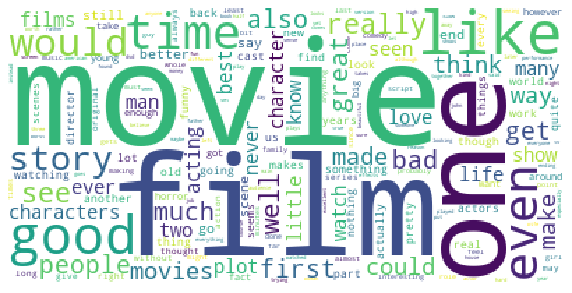

In [28]:
from wordcloud import WordCloud
wc = WordCloud(background_color="white")
wc.generate_from_frequencies(counted_tokens)
figure = plt.figure()
figure.set_size_inches(10, 10)
ax = figure.add_subplot(1, 1, 1)
ax.axis("off")
ax.imshow(wc)

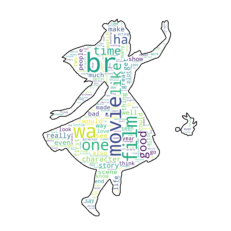

In [21]:
# 마스크 이미지 로드
import numpy as np
from PIL import Image
from os import path
import os

mask = np.array(Image.open("./image/alice_mask.png"))

# 워드 클라우드 설정
alice_wc = WordCloud(background_color="white", mask=mask, contour_width=3)

alice_wc.generate_from_frequencies(counted_tokens)

# 이미지 표시
plt.imshow(alice_wc, interpolation='bilinear')
plt.axis("off")

# 이미지 저장
alice_wc.to_file("alice_smartphone.png")